# ODE Golf Demo

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
def Ground(d):
    '''
     h = Ground(d)
     
     Returns the height (in metres) of the ground at a horizontal distance
     d (metres) from the origin.
    '''
    return 2. * (np.cos(d / 4.) - np.sin(d / 11.) - 1)

def GroundSlope(d):
    '''
     h = GroundSlope(d)
     
     Returns the slope of the ground at a horizontal distance
     d (metres) from the origin.
    '''
    return 2. * (-1. / 4 * np.sin(d / 4) - 1. / 11 * np.cos(d / 11.))

## ODE Solver Implementation

In [3]:
def solve_ode(f, tspan, y0, h, event=(lambda t, y: 1)):
    '''
     t, y = solve_ode(f, tspan, y0, h, event=[])
    
     Numerically solves the initial value problem
    
        dy(t) / dt = f(t,y)
            y(0) = y0
    
     using the Modified Euler time-stepping method.
    
     Input
       f       a Python dynamics function with calling sequence
                  dydt = f(t, y)
       tspan   2-tuple giving the start and end times, [start, end]
       y0      initial state of the system (as a 1D vector)
       h       the time step to use (this is not adaptive time stepping)
       events  an event function with calling sequence
                  val = events(t, y)
               The computation stops as soon as a negative value is
               returned by the event function.
    
     Output
       t       1D vector holding time stamps
       y       an array that holds one state vector per row (corresponding
               to the time stamps)
    '''
    # Initialize initial variables
    t = tspan[0]
    y = deepcopy(y0)
    
    # Initialize output arrays, tlst and ylst
    tlst = []
    ylst = []
    
    # Include tspan[0] and y0 in our output arrays
    tlst.append(t)
    ylst.append(list(y))
    
    # While current t is within given timespan, perform modified Euler
    while t <= tspan[1]:
        # Compute first slope
        f_1 = f(t, y)
        
        # Compute a Euler step
        y_euler = y + h * f_1
        
        # Increment our time by h
        t += h
        
        # Compute second slope
        f_2 = f(t, y_euler)
        
        # Take average of the two slopes to approximate next y
        y += 0.5 * h * (f_1 + f_2)
        
        # Compute event value
        event_value = event(t, y)
        
        # Stop computation as soon as a negative value is returned
        if event_value < 0:
            # We need to linearly interpolate the last two points
            # to find a more accurate estimate for the time and state
            # Compute previous event value which is >= 0
            previous = event(tlst[-1], ylst[-1])
            
            # Key idea is for example if our 
            # previous event value is 3 and current
            # event value is -1, then the interpolated point should be
            # 3/4 of the way from previous point to current point
            # Calculate the difference between previous event value and current
            # Note that current event value is negative, so size is positive
            size = previous - event_value
            
            # Given last point and current point, we find the slope
            slope = (y - np.array(ylst[-1])) / h
            
            # Our step will be a fraction of h depending on event values
            step = h * (previous / size)
            
            # Solve for interpolated t and y
            interpolated_t = t + step
            interpolated_y = ylst[-1] + step * slope
            
            # Add interpolated t and y into our output
            tlst.append(interpolated_t)
            ylst.append(list(interpolated_y))
            
            break

        # Add t and y to output
        tlst.append(t)
        ylst.append(list(y))

    return np.array(tlst), np.array(ylst)

## Dynamics Function

In [4]:
def projectile(t, z):
    
    # Let z1 = x'(t)
    # Let z2 = y'(t)
    # Then we have
    # z1' = -K * z1
    # z2' = -g - K * z2
    # Input z consists of (x, y, x velocity, y velocity)
    # dz/dt = (x velocity, y velocity, z1', z2')
    
    return np.array([z[2], z[3], -0.3 * z[2], -9.81 - 0.3 * z[3]])

## Event Function

In [5]:
def projectile_events(t, z):
    
    # z[0] is current x value
    # z[1] is current y value
    # Ground function returns height of ground at current x
    # If ground height is bigger than current y value then that means
    # ball has hit the ground, thus z[1] - Ground(z[0]) will change sign
    
    return z[1] - Ground(z[0])

## Simulate Golf

In [6]:
def simulate_ball(theta=50, show_graph=True):
    # Initialize variables
    S = 58
    tspan = [0, 30]
    h = 0.05
    theta_rad = theta / 180. * np.pi
    yStart = np.array([0, 0, S * np.cos(theta_rad), S * np.sin(theta_rad)])
    t = None
    y = None

    if show_graph:
        # Plot the ground
        x = np.linspace(-10, 180, 300)
        hills = Ground(x)
        plt.figure(figsize=[10,4])
        plt.plot(x,hills, 'k')
        plt.axis('equal')

        # Plot initial ball position
        plt.plot([0],[0], 'ko')

    # Simulate first 3 flights
    for _ in range(3):
        # Call ODE solver
        t,y = solve_ode(projectile, tspan, yStart, h, projectile_events)

        # Get ground slope at where ball landed
        # Convert slope into a vector
        vector = np.array([1, GroundSlope(y[-1][0])])

        # Normalize vector
        u = vector / np.linalg.norm(vector)

        # Find perpendicular vector
        U = np.array([-u[1], u[0]])

        # Find the incident velocity
        v = np.array([y[-1][2], y[-1][3]])

        # Compute new after bounce velocity using formula
        V = 0.85 * (v.dot(u) * u - v.dot(U) * U)

        # Update yStart to have positions at where the ball
        # has landed and give it the new velocity for after bounce
        yStart = np.array([y[-1][0], y[-1][1], V[0], V[1]])
        
        if show_graph:
            # Plot ball's trajectory
            plt.plot(y[:,0], y[:,1], 'b')

    if show_graph:
        # Plot final ball position
        plt.plot(y[-1,0], y[-1,1], 'ko')

        # Graph settings
        plt.title(r'$\theta$ = '+str(theta)+'$^\circ$')
        plt.xlabel('Distance (m)')
        plt.ylabel('Height (m)')
    
    # Return distance of ball travelled
    # Useful for question e)
    return y[-1, 0]

139.867332501238

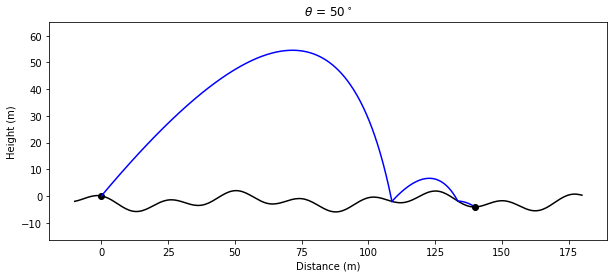

In [7]:
simulate_ball()

## Best Angle

Best Angle: 32
Best Distance: 164.11598819385546


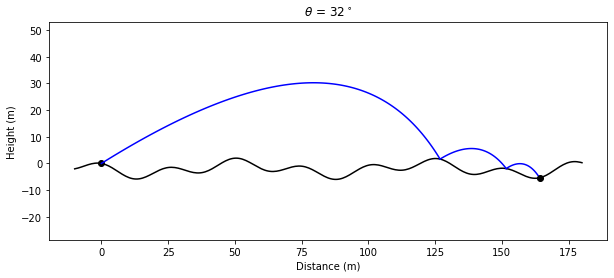

In [8]:
best_distance = -float('inf')
best_angle = None

# Try all degrees from 0 to 90
for i in range(91):
    # Find distance of ball travelled
    distance = simulate_ball(i, False)
    
    # If angle gives more distance, record it
    if distance > best_distance:
        best_distance = distance
        best_angle = i

print('Best Angle: ' + str(best_angle))
print('Best Distance: ' + str(simulate_ball(best_angle)))